# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

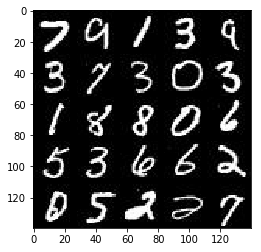

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

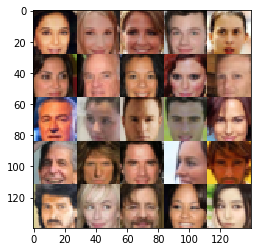

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, 
                                             image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='lr')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        layer = tf.layers.conv2d(images, 64, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.maximum(alpha*layer, layer)
        # 14x14x64
        
        layer = tf.layers.conv2d(layer, 128, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 7x7x128

        layer = tf.layers.conv2d(layer, 256, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 4x4x256
        
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # use normal ReLu instead of leaky Relu, as recommended in the original paper
    
    #alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.reshape(layer, (-1, 7, 7, 256))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 7x7x256
        
        layer = tf.layers.conv2d_transpose(layer, 128, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 14x14x128
        
        layer = tf.layers.conv2d_transpose(layer, 64, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 28x28x64
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer, 
                                            out_channel_dim, 
                                            (5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # For statistic print
    steps = 0
    print_every = 25
    show_every = 100
    
    # create inputs, losses and optimizers
    input_real, input_z, lr = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images = batch_images.reshape(batch_size, *data_shape[1:4])
                batch_images = batch_images*2
                
                # noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers (run generator more often than discriminator)
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                
                # print losses every 25 steps
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show generator output everz 100 steps
                if steps%show_every == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 25... Discriminator Loss: 1.8442... Generator Loss: 0.7569
Epoch 1/2... Step 50... Discriminator Loss: 1.8789... Generator Loss: 0.5954
Epoch 1/2... Step 75... Discriminator Loss: 1.7123... Generator Loss: 0.5888
Epoch 1/2... Step 100... Discriminator Loss: 1.7467... Generator Loss: 0.4308


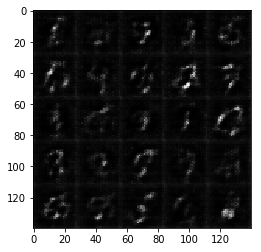

Epoch 1/2... Step 125... Discriminator Loss: 1.4529... Generator Loss: 0.7718
Epoch 1/2... Step 150... Discriminator Loss: 1.6976... Generator Loss: 0.4655
Epoch 1/2... Step 175... Discriminator Loss: 1.4553... Generator Loss: 0.5343
Epoch 1/2... Step 200... Discriminator Loss: 1.4567... Generator Loss: 0.6066


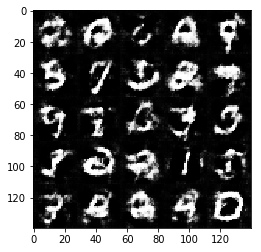

Epoch 1/2... Step 225... Discriminator Loss: 1.6409... Generator Loss: 0.4238
Epoch 1/2... Step 250... Discriminator Loss: 1.5224... Generator Loss: 0.7908
Epoch 1/2... Step 275... Discriminator Loss: 1.3488... Generator Loss: 0.9040
Epoch 1/2... Step 300... Discriminator Loss: 1.4977... Generator Loss: 0.8595


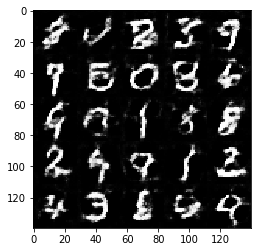

Epoch 1/2... Step 325... Discriminator Loss: 1.5517... Generator Loss: 0.6884
Epoch 1/2... Step 350... Discriminator Loss: 1.4786... Generator Loss: 0.6508
Epoch 1/2... Step 375... Discriminator Loss: 1.4720... Generator Loss: 1.0076
Epoch 1/2... Step 400... Discriminator Loss: 1.5184... Generator Loss: 0.5486


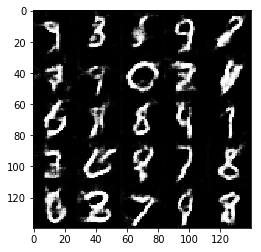

Epoch 1/2... Step 425... Discriminator Loss: 1.4719... Generator Loss: 0.8458
Epoch 1/2... Step 450... Discriminator Loss: 1.4056... Generator Loss: 0.6830
Epoch 1/2... Step 475... Discriminator Loss: 1.4425... Generator Loss: 1.1481
Epoch 1/2... Step 500... Discriminator Loss: 1.5624... Generator Loss: 1.1644


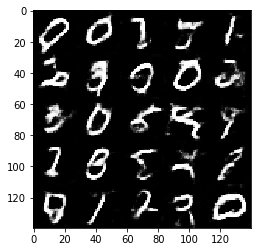

Epoch 1/2... Step 525... Discriminator Loss: 1.3895... Generator Loss: 0.7716
Epoch 1/2... Step 550... Discriminator Loss: 1.5317... Generator Loss: 0.4992
Epoch 1/2... Step 575... Discriminator Loss: 1.4294... Generator Loss: 0.8131
Epoch 1/2... Step 600... Discriminator Loss: 1.4470... Generator Loss: 0.7438


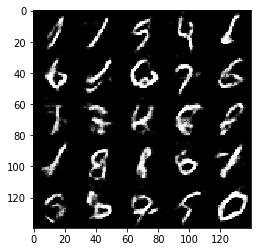

Epoch 1/2... Step 625... Discriminator Loss: 1.4728... Generator Loss: 0.5812
Epoch 1/2... Step 650... Discriminator Loss: 1.4107... Generator Loss: 0.6491
Epoch 1/2... Step 675... Discriminator Loss: 1.4662... Generator Loss: 0.6023
Epoch 1/2... Step 700... Discriminator Loss: 1.5221... Generator Loss: 0.9844


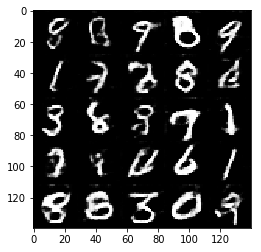

Epoch 1/2... Step 725... Discriminator Loss: 1.4921... Generator Loss: 0.8338
Epoch 1/2... Step 750... Discriminator Loss: 1.3735... Generator Loss: 0.7258
Epoch 1/2... Step 775... Discriminator Loss: 1.3770... Generator Loss: 0.7333
Epoch 1/2... Step 800... Discriminator Loss: 1.8824... Generator Loss: 1.1133


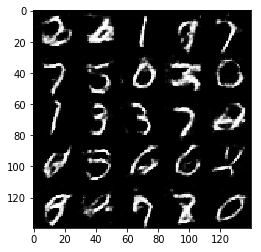

Epoch 1/2... Step 825... Discriminator Loss: 1.4896... Generator Loss: 0.5701
Epoch 1/2... Step 850... Discriminator Loss: 1.4819... Generator Loss: 0.6906
Epoch 1/2... Step 875... Discriminator Loss: 1.3885... Generator Loss: 0.5862
Epoch 1/2... Step 900... Discriminator Loss: 1.3993... Generator Loss: 0.6334


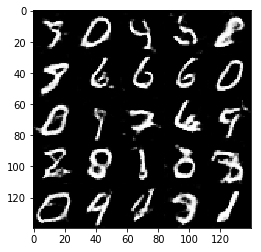

Epoch 1/2... Step 925... Discriminator Loss: 1.3816... Generator Loss: 0.6354
Epoch 2/2... Step 950... Discriminator Loss: 1.5016... Generator Loss: 0.4709
Epoch 2/2... Step 975... Discriminator Loss: 1.5915... Generator Loss: 0.3918
Epoch 2/2... Step 1000... Discriminator Loss: 1.4696... Generator Loss: 0.5719


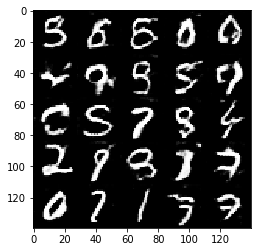

Epoch 2/2... Step 1025... Discriminator Loss: 1.5018... Generator Loss: 0.5367
Epoch 2/2... Step 1050... Discriminator Loss: 1.4109... Generator Loss: 0.6886
Epoch 2/2... Step 1075... Discriminator Loss: 1.4601... Generator Loss: 0.7306
Epoch 2/2... Step 1100... Discriminator Loss: 1.4932... Generator Loss: 0.6201


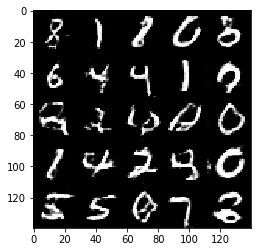

Epoch 2/2... Step 1125... Discriminator Loss: 1.4227... Generator Loss: 0.8105
Epoch 2/2... Step 1150... Discriminator Loss: 1.5554... Generator Loss: 0.5492
Epoch 2/2... Step 1175... Discriminator Loss: 1.3404... Generator Loss: 0.6390
Epoch 2/2... Step 1200... Discriminator Loss: 1.4108... Generator Loss: 0.9001


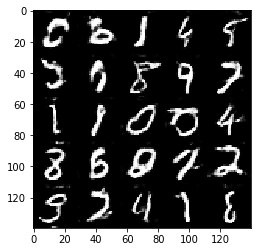

Epoch 2/2... Step 1225... Discriminator Loss: 1.4021... Generator Loss: 0.7826
Epoch 2/2... Step 1250... Discriminator Loss: 1.7372... Generator Loss: 1.1920
Epoch 2/2... Step 1275... Discriminator Loss: 1.4110... Generator Loss: 0.8258
Epoch 2/2... Step 1300... Discriminator Loss: 1.4150... Generator Loss: 0.7390


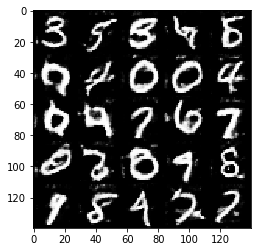

Epoch 2/2... Step 1325... Discriminator Loss: 1.5706... Generator Loss: 0.5102
Epoch 2/2... Step 1350... Discriminator Loss: 1.3457... Generator Loss: 1.1947
Epoch 2/2... Step 1375... Discriminator Loss: 1.3328... Generator Loss: 0.7970
Epoch 2/2... Step 1400... Discriminator Loss: 1.4080... Generator Loss: 0.6849


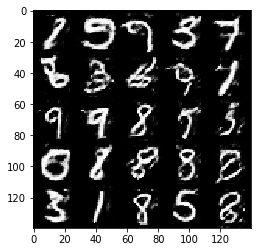

Epoch 2/2... Step 1425... Discriminator Loss: 1.3565... Generator Loss: 0.9434
Epoch 2/2... Step 1450... Discriminator Loss: 1.5557... Generator Loss: 0.4384
Epoch 2/2... Step 1475... Discriminator Loss: 1.5103... Generator Loss: 0.4575
Epoch 2/2... Step 1500... Discriminator Loss: 1.2973... Generator Loss: 0.9601


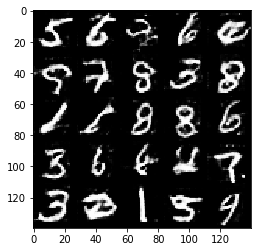

Epoch 2/2... Step 1525... Discriminator Loss: 1.3650... Generator Loss: 0.8813
Epoch 2/2... Step 1550... Discriminator Loss: 1.5567... Generator Loss: 0.4556
Epoch 2/2... Step 1575... Discriminator Loss: 1.4175... Generator Loss: 0.6311
Epoch 2/2... Step 1600... Discriminator Loss: 1.4418... Generator Loss: 0.9088


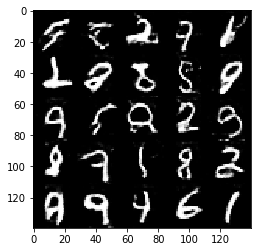

Epoch 2/2... Step 1625... Discriminator Loss: 1.3679... Generator Loss: 0.8331
Epoch 2/2... Step 1650... Discriminator Loss: 1.3375... Generator Loss: 0.8300
Epoch 2/2... Step 1675... Discriminator Loss: 1.3775... Generator Loss: 0.5750
Epoch 2/2... Step 1700... Discriminator Loss: 1.2731... Generator Loss: 0.9587


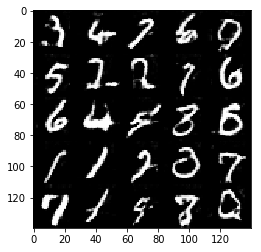

Epoch 2/2... Step 1725... Discriminator Loss: 1.6210... Generator Loss: 0.3871
Epoch 2/2... Step 1750... Discriminator Loss: 1.5256... Generator Loss: 0.5713
Epoch 2/2... Step 1775... Discriminator Loss: 1.5247... Generator Loss: 1.4357
Epoch 2/2... Step 1800... Discriminator Loss: 1.5271... Generator Loss: 0.4591


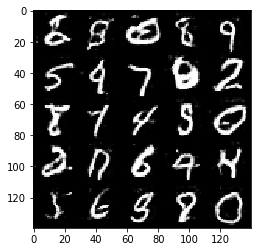

Epoch 2/2... Step 1825... Discriminator Loss: 1.4910... Generator Loss: 1.4794
Epoch 2/2... Step 1850... Discriminator Loss: 1.1656... Generator Loss: 0.9953


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Step 25... Discriminator Loss: 2.3849... Generator Loss: 0.5266
Epoch 1/2... Step 50... Discriminator Loss: 1.8412... Generator Loss: 0.5432
Epoch 1/2... Step 75... Discriminator Loss: 1.5216... Generator Loss: 0.7768
Epoch 1/2... Step 100... Discriminator Loss: 1.5840... Generator Loss: 0.6434


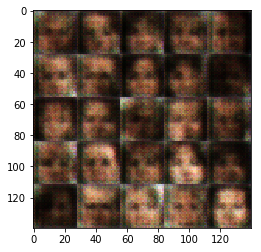

Epoch 1/2... Step 125... Discriminator Loss: 1.6814... Generator Loss: 0.6444
Epoch 1/2... Step 150... Discriminator Loss: 1.6320... Generator Loss: 0.7280
Epoch 1/2... Step 175... Discriminator Loss: 1.5650... Generator Loss: 0.6906
Epoch 1/2... Step 200... Discriminator Loss: 1.5372... Generator Loss: 0.6030


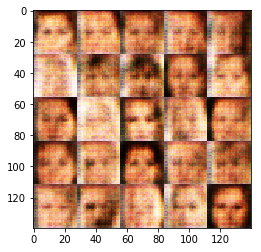

Epoch 1/2... Step 225... Discriminator Loss: 1.6382... Generator Loss: 0.5963
Epoch 1/2... Step 250... Discriminator Loss: 1.7204... Generator Loss: 0.6476
Epoch 1/2... Step 275... Discriminator Loss: 1.5649... Generator Loss: 0.6853
Epoch 1/2... Step 300... Discriminator Loss: 1.4880... Generator Loss: 0.6416


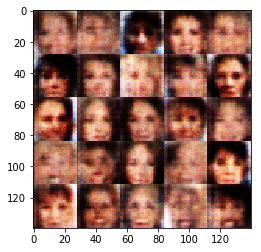

Epoch 1/2... Step 325... Discriminator Loss: 1.4627... Generator Loss: 0.7138
Epoch 1/2... Step 350... Discriminator Loss: 1.5482... Generator Loss: 0.6986
Epoch 1/2... Step 375... Discriminator Loss: 1.4659... Generator Loss: 0.7078
Epoch 1/2... Step 400... Discriminator Loss: 1.4280... Generator Loss: 0.7677


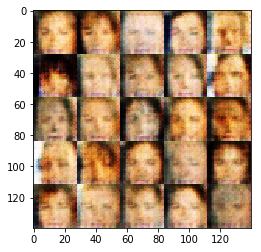

Epoch 1/2... Step 425... Discriminator Loss: 1.5849... Generator Loss: 0.5830
Epoch 1/2... Step 450... Discriminator Loss: 1.5057... Generator Loss: 0.6776
Epoch 1/2... Step 475... Discriminator Loss: 1.5247... Generator Loss: 0.6743
Epoch 1/2... Step 500... Discriminator Loss: 1.4757... Generator Loss: 0.7029


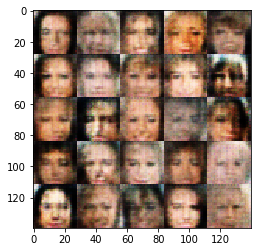

Epoch 1/2... Step 525... Discriminator Loss: 1.4063... Generator Loss: 0.7540
Epoch 1/2... Step 550... Discriminator Loss: 1.5334... Generator Loss: 0.6113
Epoch 1/2... Step 575... Discriminator Loss: 1.4949... Generator Loss: 0.7315
Epoch 1/2... Step 600... Discriminator Loss: 1.4076... Generator Loss: 0.7643


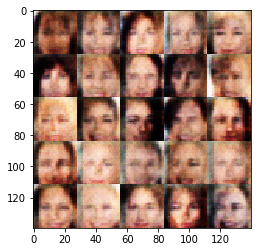

Epoch 1/2... Step 625... Discriminator Loss: 1.3984... Generator Loss: 0.8355
Epoch 1/2... Step 650... Discriminator Loss: 1.4339... Generator Loss: 0.6739
Epoch 1/2... Step 675... Discriminator Loss: 1.4506... Generator Loss: 0.7671
Epoch 1/2... Step 700... Discriminator Loss: 1.3965... Generator Loss: 0.8175


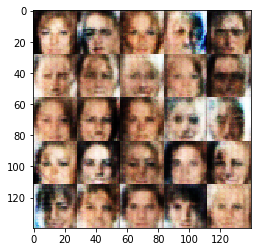

Epoch 1/2... Step 725... Discriminator Loss: 1.4849... Generator Loss: 0.7992
Epoch 1/2... Step 750... Discriminator Loss: 1.4570... Generator Loss: 0.7261
Epoch 1/2... Step 775... Discriminator Loss: 1.4208... Generator Loss: 0.7436
Epoch 1/2... Step 800... Discriminator Loss: 1.4639... Generator Loss: 0.7376


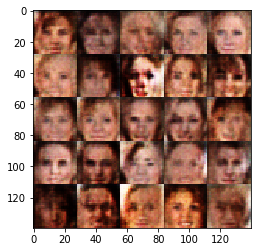

Epoch 1/2... Step 825... Discriminator Loss: 1.5103... Generator Loss: 0.7617
Epoch 1/2... Step 850... Discriminator Loss: 1.4682... Generator Loss: 0.6948
Epoch 1/2... Step 875... Discriminator Loss: 1.4727... Generator Loss: 0.7052
Epoch 1/2... Step 900... Discriminator Loss: 1.3942... Generator Loss: 0.7462


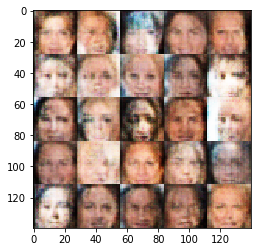

Epoch 1/2... Step 925... Discriminator Loss: 1.5395... Generator Loss: 0.7742
Epoch 1/2... Step 950... Discriminator Loss: 1.4951... Generator Loss: 0.7098
Epoch 1/2... Step 975... Discriminator Loss: 1.4697... Generator Loss: 0.7987
Epoch 1/2... Step 1000... Discriminator Loss: 1.3958... Generator Loss: 0.7782


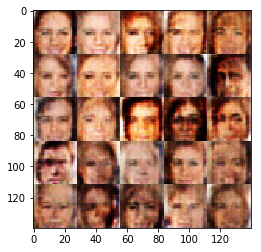

Epoch 1/2... Step 1025... Discriminator Loss: 1.4325... Generator Loss: 0.7011
Epoch 1/2... Step 1050... Discriminator Loss: 1.4379... Generator Loss: 0.7376
Epoch 1/2... Step 1075... Discriminator Loss: 1.4715... Generator Loss: 0.8341
Epoch 1/2... Step 1100... Discriminator Loss: 1.4848... Generator Loss: 0.7815


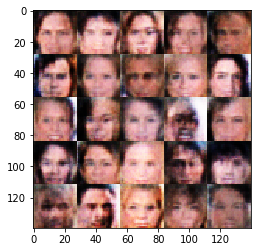

Epoch 1/2... Step 1125... Discriminator Loss: 1.3848... Generator Loss: 0.8217
Epoch 1/2... Step 1150... Discriminator Loss: 1.4174... Generator Loss: 0.6815
Epoch 1/2... Step 1175... Discriminator Loss: 1.4078... Generator Loss: 0.7363
Epoch 1/2... Step 1200... Discriminator Loss: 1.4945... Generator Loss: 0.7834


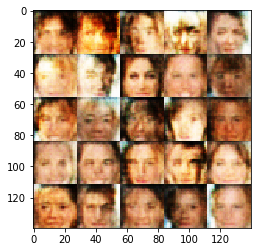

Epoch 1/2... Step 1225... Discriminator Loss: 1.4221... Generator Loss: 0.8469
Epoch 1/2... Step 1250... Discriminator Loss: 1.4206... Generator Loss: 0.8112
Epoch 1/2... Step 1275... Discriminator Loss: 1.5695... Generator Loss: 0.6422
Epoch 1/2... Step 1300... Discriminator Loss: 1.4501... Generator Loss: 0.7089


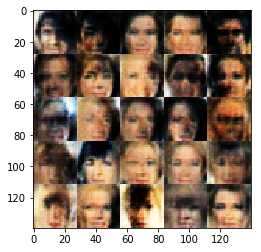

Epoch 1/2... Step 1325... Discriminator Loss: 1.4279... Generator Loss: 0.7335
Epoch 1/2... Step 1350... Discriminator Loss: 1.4539... Generator Loss: 0.7935
Epoch 1/2... Step 1375... Discriminator Loss: 1.3986... Generator Loss: 0.7267
Epoch 1/2... Step 1400... Discriminator Loss: 1.3610... Generator Loss: 0.7798


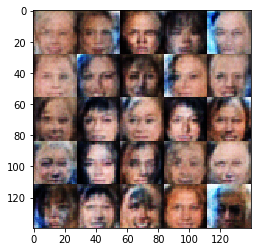

Epoch 1/2... Step 1425... Discriminator Loss: 1.4230... Generator Loss: 0.6952
Epoch 1/2... Step 1450... Discriminator Loss: 1.4661... Generator Loss: 0.7573
Epoch 1/2... Step 1475... Discriminator Loss: 1.4594... Generator Loss: 0.6853
Epoch 1/2... Step 1500... Discriminator Loss: 1.5182... Generator Loss: 0.7012


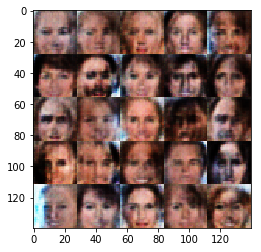

Epoch 1/2... Step 1525... Discriminator Loss: 1.4443... Generator Loss: 0.7756
Epoch 1/2... Step 1550... Discriminator Loss: 1.3702... Generator Loss: 0.7675
Epoch 1/2... Step 1575... Discriminator Loss: 1.4692... Generator Loss: 0.7595
Epoch 1/2... Step 1600... Discriminator Loss: 1.4075... Generator Loss: 0.7918


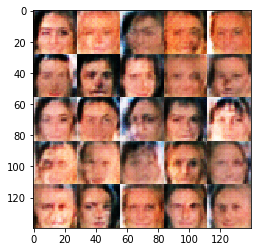

Epoch 1/2... Step 1625... Discriminator Loss: 1.3771... Generator Loss: 0.7777
Epoch 1/2... Step 1650... Discriminator Loss: 1.4516... Generator Loss: 0.7970
Epoch 1/2... Step 1675... Discriminator Loss: 1.4685... Generator Loss: 0.7497
Epoch 1/2... Step 1700... Discriminator Loss: 1.4255... Generator Loss: 0.8047


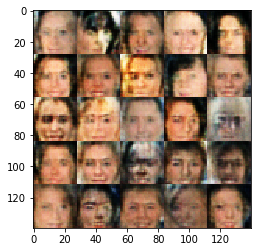

Epoch 1/2... Step 1725... Discriminator Loss: 1.3825... Generator Loss: 0.7973
Epoch 1/2... Step 1750... Discriminator Loss: 1.4056... Generator Loss: 0.8225
Epoch 1/2... Step 1775... Discriminator Loss: 1.3886... Generator Loss: 0.8351
Epoch 1/2... Step 1800... Discriminator Loss: 1.3739... Generator Loss: 0.7975


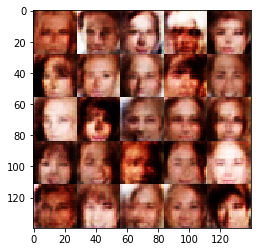

Epoch 1/2... Step 1825... Discriminator Loss: 1.4133... Generator Loss: 0.7398
Epoch 1/2... Step 1850... Discriminator Loss: 1.4472... Generator Loss: 0.7008
Epoch 1/2... Step 1875... Discriminator Loss: 1.3747... Generator Loss: 0.7550
Epoch 1/2... Step 1900... Discriminator Loss: 1.4043... Generator Loss: 0.7169


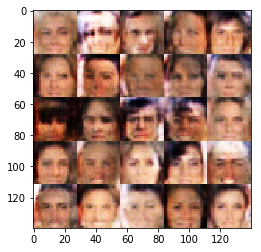

Epoch 1/2... Step 1925... Discriminator Loss: 1.4352... Generator Loss: 0.8090
Epoch 1/2... Step 1950... Discriminator Loss: 1.5016... Generator Loss: 0.7237
Epoch 1/2... Step 1975... Discriminator Loss: 1.4528... Generator Loss: 0.6901
Epoch 1/2... Step 2000... Discriminator Loss: 1.4542... Generator Loss: 0.6894


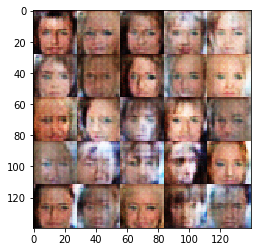

Epoch 1/2... Step 2025... Discriminator Loss: 1.4072... Generator Loss: 0.7519
Epoch 1/2... Step 2050... Discriminator Loss: 1.3879... Generator Loss: 0.7666
Epoch 1/2... Step 2075... Discriminator Loss: 1.4235... Generator Loss: 0.7675
Epoch 1/2... Step 2100... Discriminator Loss: 1.4092... Generator Loss: 0.7425


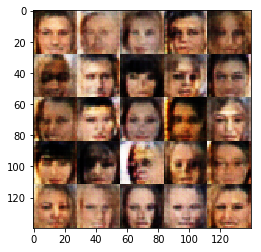

Epoch 1/2... Step 2125... Discriminator Loss: 1.4466... Generator Loss: 0.6793
Epoch 1/2... Step 2150... Discriminator Loss: 1.4221... Generator Loss: 0.7303
Epoch 1/2... Step 2175... Discriminator Loss: 1.4276... Generator Loss: 0.7166
Epoch 1/2... Step 2200... Discriminator Loss: 1.4911... Generator Loss: 0.6276


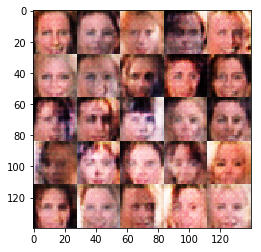

Epoch 1/2... Step 2225... Discriminator Loss: 1.3714... Generator Loss: 0.8009
Epoch 1/2... Step 2250... Discriminator Loss: 1.4131... Generator Loss: 0.7252
Epoch 1/2... Step 2275... Discriminator Loss: 1.4280... Generator Loss: 0.7985
Epoch 1/2... Step 2300... Discriminator Loss: 1.3690... Generator Loss: 0.7642


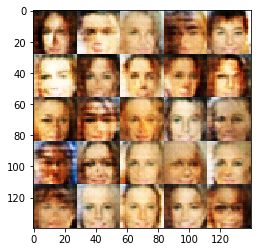

Epoch 1/2... Step 2325... Discriminator Loss: 1.4005... Generator Loss: 0.7624
Epoch 1/2... Step 2350... Discriminator Loss: 1.4471... Generator Loss: 0.7304
Epoch 1/2... Step 2375... Discriminator Loss: 1.3722... Generator Loss: 0.7819
Epoch 1/2... Step 2400... Discriminator Loss: 1.4394... Generator Loss: 0.7774


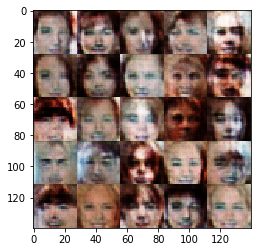

Epoch 1/2... Step 2425... Discriminator Loss: 1.4137... Generator Loss: 0.7452
Epoch 1/2... Step 2450... Discriminator Loss: 1.4243... Generator Loss: 0.7292
Epoch 1/2... Step 2475... Discriminator Loss: 1.4082... Generator Loss: 0.7783
Epoch 1/2... Step 2500... Discriminator Loss: 1.3960... Generator Loss: 0.7800


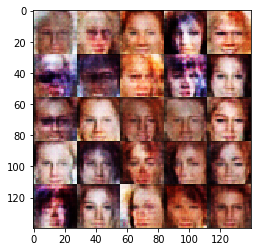

Epoch 1/2... Step 2525... Discriminator Loss: 1.3991... Generator Loss: 0.7834
Epoch 1/2... Step 2550... Discriminator Loss: 1.4327... Generator Loss: 0.7844
Epoch 1/2... Step 2575... Discriminator Loss: 1.3787... Generator Loss: 0.8719
Epoch 1/2... Step 2600... Discriminator Loss: 1.4576... Generator Loss: 0.7051


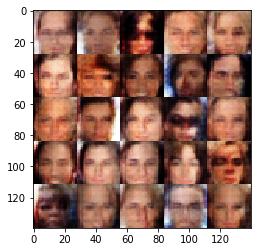

Epoch 1/2... Step 2625... Discriminator Loss: 1.4580... Generator Loss: 0.6959
Epoch 1/2... Step 2650... Discriminator Loss: 1.3649... Generator Loss: 0.8291
Epoch 1/2... Step 2675... Discriminator Loss: 1.4171... Generator Loss: 0.7944
Epoch 1/2... Step 2700... Discriminator Loss: 1.3995... Generator Loss: 0.8297


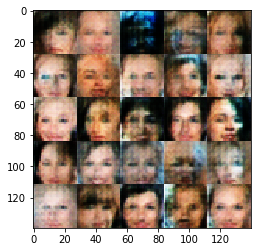

Epoch 1/2... Step 2725... Discriminator Loss: 1.4342... Generator Loss: 0.7107
Epoch 1/2... Step 2750... Discriminator Loss: 1.4030... Generator Loss: 0.7052
Epoch 1/2... Step 2775... Discriminator Loss: 1.3963... Generator Loss: 0.8330
Epoch 1/2... Step 2800... Discriminator Loss: 1.4387... Generator Loss: 0.8012


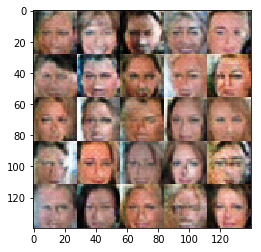

Epoch 1/2... Step 2825... Discriminator Loss: 1.3765... Generator Loss: 0.7957
Epoch 1/2... Step 2850... Discriminator Loss: 1.4213... Generator Loss: 0.8176
Epoch 1/2... Step 2875... Discriminator Loss: 1.3873... Generator Loss: 0.8300
Epoch 1/2... Step 2900... Discriminator Loss: 1.3998... Generator Loss: 0.8432


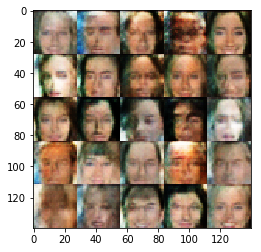

Epoch 1/2... Step 2925... Discriminator Loss: 1.4469... Generator Loss: 0.7210
Epoch 1/2... Step 2950... Discriminator Loss: 1.4001... Generator Loss: 0.7708
Epoch 1/2... Step 2975... Discriminator Loss: 1.4338... Generator Loss: 0.7270
Epoch 1/2... Step 3000... Discriminator Loss: 1.4086... Generator Loss: 0.7020


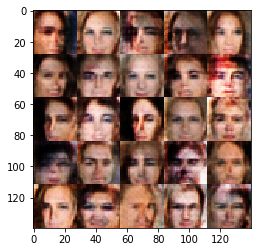

Epoch 1/2... Step 3025... Discriminator Loss: 1.4143... Generator Loss: 0.7545
Epoch 1/2... Step 3050... Discriminator Loss: 1.3900... Generator Loss: 0.7525
Epoch 1/2... Step 3075... Discriminator Loss: 1.4244... Generator Loss: 0.7606
Epoch 1/2... Step 3100... Discriminator Loss: 1.3776... Generator Loss: 0.7652


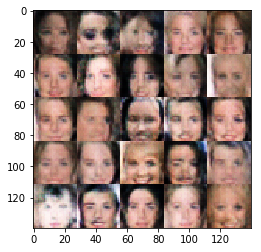

Epoch 1/2... Step 3125... Discriminator Loss: 1.4505... Generator Loss: 0.7681
Epoch 1/2... Step 3150... Discriminator Loss: 1.3795... Generator Loss: 0.7812
Epoch 2/2... Step 3175... Discriminator Loss: 1.3898... Generator Loss: 0.8576
Epoch 2/2... Step 3200... Discriminator Loss: 1.4056... Generator Loss: 0.7759


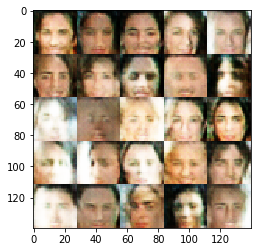

Epoch 2/2... Step 3225... Discriminator Loss: 1.3973... Generator Loss: 0.7251
Epoch 2/2... Step 3250... Discriminator Loss: 1.4174... Generator Loss: 0.7498
Epoch 2/2... Step 3275... Discriminator Loss: 1.4249... Generator Loss: 0.7116
Epoch 2/2... Step 3300... Discriminator Loss: 1.4319... Generator Loss: 0.7519


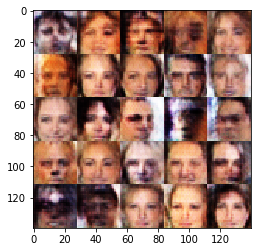

Epoch 2/2... Step 3325... Discriminator Loss: 1.4027... Generator Loss: 0.7235
Epoch 2/2... Step 3350... Discriminator Loss: 1.3913... Generator Loss: 0.7868
Epoch 2/2... Step 3375... Discriminator Loss: 1.4184... Generator Loss: 0.7967
Epoch 2/2... Step 3400... Discriminator Loss: 1.4108... Generator Loss: 0.7884


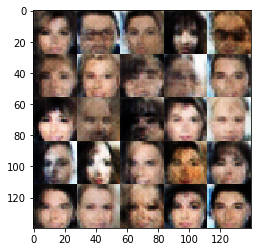

Epoch 2/2... Step 3425... Discriminator Loss: 1.4041... Generator Loss: 0.7916
Epoch 2/2... Step 3450... Discriminator Loss: 1.4143... Generator Loss: 0.7642
Epoch 2/2... Step 3475... Discriminator Loss: 1.3856... Generator Loss: 0.8160
Epoch 2/2... Step 3500... Discriminator Loss: 1.4157... Generator Loss: 0.6860


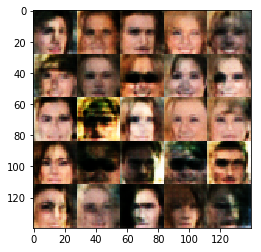

Epoch 2/2... Step 3525... Discriminator Loss: 1.4187... Generator Loss: 0.7804
Epoch 2/2... Step 3550... Discriminator Loss: 1.4122... Generator Loss: 0.7281
Epoch 2/2... Step 3575... Discriminator Loss: 1.4106... Generator Loss: 0.8394
Epoch 2/2... Step 3600... Discriminator Loss: 1.4060... Generator Loss: 0.7925


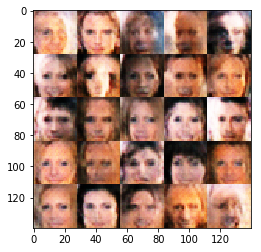

Epoch 2/2... Step 3625... Discriminator Loss: 1.5128... Generator Loss: 0.7303
Epoch 2/2... Step 3650... Discriminator Loss: 1.4213... Generator Loss: 0.7491
Epoch 2/2... Step 3675... Discriminator Loss: 1.4001... Generator Loss: 0.7690
Epoch 2/2... Step 3700... Discriminator Loss: 1.4188... Generator Loss: 0.6790


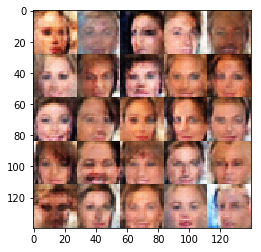

Epoch 2/2... Step 3725... Discriminator Loss: 1.3805... Generator Loss: 0.7157
Epoch 2/2... Step 3750... Discriminator Loss: 1.4196... Generator Loss: 0.7420
Epoch 2/2... Step 3775... Discriminator Loss: 1.4298... Generator Loss: 0.7372
Epoch 2/2... Step 3800... Discriminator Loss: 1.4139... Generator Loss: 0.7967


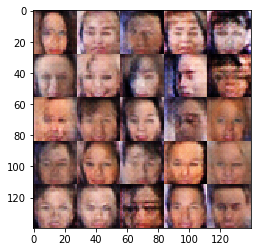

Epoch 2/2... Step 3825... Discriminator Loss: 1.4164... Generator Loss: 0.7182
Epoch 2/2... Step 3850... Discriminator Loss: 1.4686... Generator Loss: 0.7269
Epoch 2/2... Step 3875... Discriminator Loss: 1.4199... Generator Loss: 0.6849
Epoch 2/2... Step 3900... Discriminator Loss: 1.3957... Generator Loss: 0.7840


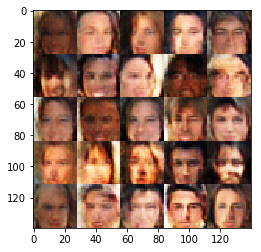

Epoch 2/2... Step 3925... Discriminator Loss: 1.3893... Generator Loss: 0.7543
Epoch 2/2... Step 3950... Discriminator Loss: 1.3926... Generator Loss: 0.8362
Epoch 2/2... Step 3975... Discriminator Loss: 1.4194... Generator Loss: 0.8322
Epoch 2/2... Step 4000... Discriminator Loss: 1.4514... Generator Loss: 0.6997


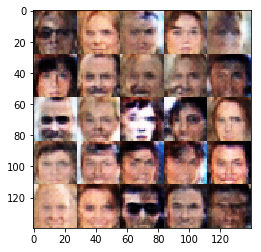

Epoch 2/2... Step 4025... Discriminator Loss: 1.4368... Generator Loss: 0.8106
Epoch 2/2... Step 4050... Discriminator Loss: 1.3930... Generator Loss: 0.8021
Epoch 2/2... Step 4075... Discriminator Loss: 1.4034... Generator Loss: 0.7910
Epoch 2/2... Step 4100... Discriminator Loss: 1.4194... Generator Loss: 0.7173


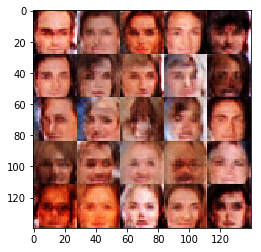

Epoch 2/2... Step 4125... Discriminator Loss: 1.4008... Generator Loss: 0.7507
Epoch 2/2... Step 4150... Discriminator Loss: 1.3907... Generator Loss: 0.8755
Epoch 2/2... Step 4175... Discriminator Loss: 1.3720... Generator Loss: 0.8086
Epoch 2/2... Step 4200... Discriminator Loss: 1.4028... Generator Loss: 0.7703


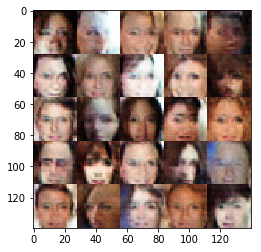

Epoch 2/2... Step 4225... Discriminator Loss: 1.3912... Generator Loss: 0.7829
Epoch 2/2... Step 4250... Discriminator Loss: 1.3786... Generator Loss: 0.8056
Epoch 2/2... Step 4275... Discriminator Loss: 1.4076... Generator Loss: 0.8057
Epoch 2/2... Step 4300... Discriminator Loss: 1.4093... Generator Loss: 0.7828


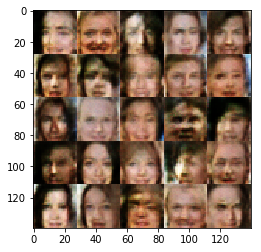

Epoch 2/2... Step 4325... Discriminator Loss: 1.4093... Generator Loss: 0.6754
Epoch 2/2... Step 4350... Discriminator Loss: 1.4029... Generator Loss: 0.8220
Epoch 2/2... Step 4375... Discriminator Loss: 1.4264... Generator Loss: 0.8322
Epoch 2/2... Step 4400... Discriminator Loss: 1.3843... Generator Loss: 0.7926


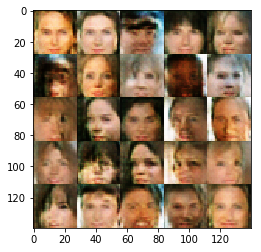

Epoch 2/2... Step 4425... Discriminator Loss: 1.4303... Generator Loss: 0.6677
Epoch 2/2... Step 4450... Discriminator Loss: 1.4068... Generator Loss: 0.7848
Epoch 2/2... Step 4475... Discriminator Loss: 1.4254... Generator Loss: 0.7109
Epoch 2/2... Step 4500... Discriminator Loss: 1.3989... Generator Loss: 0.7621


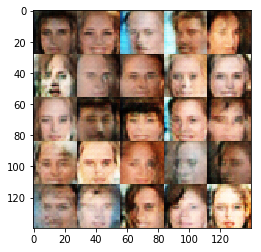

Epoch 2/2... Step 4525... Discriminator Loss: 1.3870... Generator Loss: 0.8009
Epoch 2/2... Step 4550... Discriminator Loss: 1.4035... Generator Loss: 0.7601
Epoch 2/2... Step 4575... Discriminator Loss: 1.4076... Generator Loss: 0.8239
Epoch 2/2... Step 4600... Discriminator Loss: 1.3946... Generator Loss: 0.8049


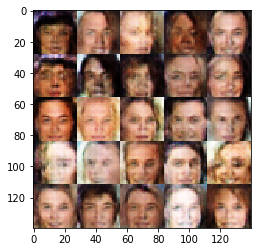

Epoch 2/2... Step 4625... Discriminator Loss: 1.4515... Generator Loss: 0.8465
Epoch 2/2... Step 4650... Discriminator Loss: 1.3801... Generator Loss: 0.7475
Epoch 2/2... Step 4675... Discriminator Loss: 1.3849... Generator Loss: 0.7907
Epoch 2/2... Step 4700... Discriminator Loss: 1.3835... Generator Loss: 0.7266


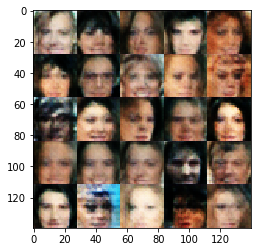

Epoch 2/2... Step 4725... Discriminator Loss: 1.3911... Generator Loss: 0.7448
Epoch 2/2... Step 4750... Discriminator Loss: 1.4559... Generator Loss: 0.7483
Epoch 2/2... Step 4775... Discriminator Loss: 1.4050... Generator Loss: 0.7845
Epoch 2/2... Step 4800... Discriminator Loss: 1.3878... Generator Loss: 0.8371


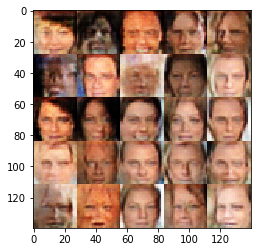

Epoch 2/2... Step 4825... Discriminator Loss: 1.4218... Generator Loss: 0.6563
Epoch 2/2... Step 4850... Discriminator Loss: 1.3839... Generator Loss: 0.7627
Epoch 2/2... Step 4875... Discriminator Loss: 1.3844... Generator Loss: 0.8014
Epoch 2/2... Step 4900... Discriminator Loss: 1.4310... Generator Loss: 0.7621


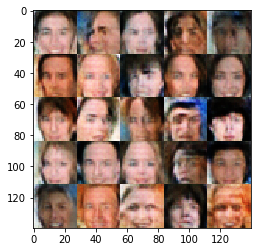

Epoch 2/2... Step 4925... Discriminator Loss: 1.3926... Generator Loss: 0.7704
Epoch 2/2... Step 4950... Discriminator Loss: 1.4019... Generator Loss: 0.7452
Epoch 2/2... Step 4975... Discriminator Loss: 1.4181... Generator Loss: 0.7584
Epoch 2/2... Step 5000... Discriminator Loss: 1.4176... Generator Loss: 0.7050


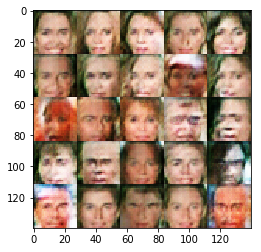

Epoch 2/2... Step 5025... Discriminator Loss: 1.4016... Generator Loss: 0.6920
Epoch 2/2... Step 5050... Discriminator Loss: 1.4231... Generator Loss: 0.7291
Epoch 2/2... Step 5075... Discriminator Loss: 1.4104... Generator Loss: 0.8164
Epoch 2/2... Step 5100... Discriminator Loss: 1.4053... Generator Loss: 0.7864


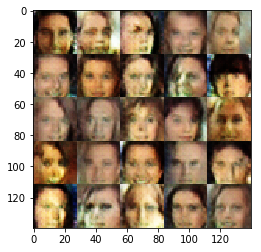

Epoch 2/2... Step 5125... Discriminator Loss: 1.4223... Generator Loss: 0.7790
Epoch 2/2... Step 5150... Discriminator Loss: 1.3833... Generator Loss: 0.8132
Epoch 2/2... Step 5175... Discriminator Loss: 1.4095... Generator Loss: 0.8832
Epoch 2/2... Step 5200... Discriminator Loss: 1.3908... Generator Loss: 0.8106


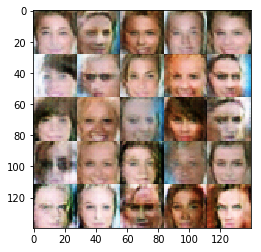

Epoch 2/2... Step 5225... Discriminator Loss: 1.3797... Generator Loss: 0.8432
Epoch 2/2... Step 5250... Discriminator Loss: 1.3864... Generator Loss: 0.7768
Epoch 2/2... Step 5275... Discriminator Loss: 1.4459... Generator Loss: 0.7301
Epoch 2/2... Step 5300... Discriminator Loss: 1.4195... Generator Loss: 0.7725


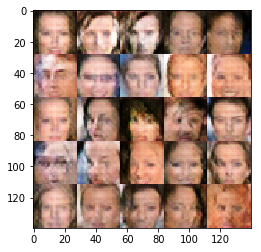

Epoch 2/2... Step 5325... Discriminator Loss: 1.3995... Generator Loss: 0.7709
Epoch 2/2... Step 5350... Discriminator Loss: 1.3951... Generator Loss: 0.7257
Epoch 2/2... Step 5375... Discriminator Loss: 1.4112... Generator Loss: 0.8565
Epoch 2/2... Step 5400... Discriminator Loss: 1.3844... Generator Loss: 0.7877


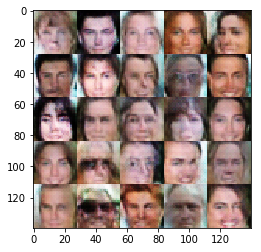

Epoch 2/2... Step 5425... Discriminator Loss: 1.3852... Generator Loss: 0.7996
Epoch 2/2... Step 5450... Discriminator Loss: 1.3866... Generator Loss: 0.7145
Epoch 2/2... Step 5475... Discriminator Loss: 1.4114... Generator Loss: 0.7930
Epoch 2/2... Step 5500... Discriminator Loss: 1.4201... Generator Loss: 0.7004


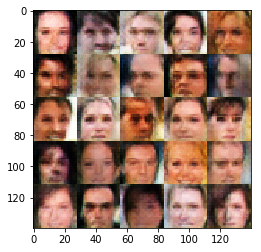

Epoch 2/2... Step 5525... Discriminator Loss: 1.3940... Generator Loss: 0.7613
Epoch 2/2... Step 5550... Discriminator Loss: 1.3979... Generator Loss: 0.7034
Epoch 2/2... Step 5575... Discriminator Loss: 1.3807... Generator Loss: 0.7596
Epoch 2/2... Step 5600... Discriminator Loss: 1.3899... Generator Loss: 0.7524


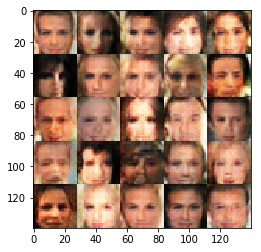

Epoch 2/2... Step 5625... Discriminator Loss: 1.3991... Generator Loss: 0.7789
Epoch 2/2... Step 5650... Discriminator Loss: 1.3961... Generator Loss: 0.7628
Epoch 2/2... Step 5675... Discriminator Loss: 1.3813... Generator Loss: 0.8217
Epoch 2/2... Step 5700... Discriminator Loss: 1.4042... Generator Loss: 0.6720


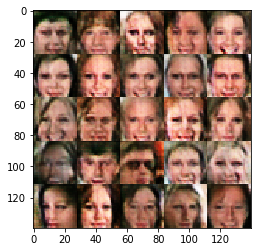

Epoch 2/2... Step 5725... Discriminator Loss: 1.4197... Generator Loss: 0.7762
Epoch 2/2... Step 5750... Discriminator Loss: 1.4141... Generator Loss: 0.7327
Epoch 2/2... Step 5775... Discriminator Loss: 1.4046... Generator Loss: 0.7952
Epoch 2/2... Step 5800... Discriminator Loss: 1.4245... Generator Loss: 0.9013


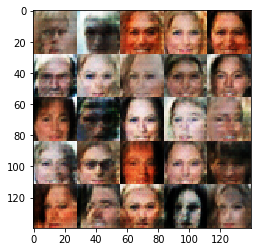

Epoch 2/2... Step 5825... Discriminator Loss: 1.4076... Generator Loss: 0.7288
Epoch 2/2... Step 5850... Discriminator Loss: 1.4109... Generator Loss: 0.7161
Epoch 2/2... Step 5875... Discriminator Loss: 1.3792... Generator Loss: 0.7831
Epoch 2/2... Step 5900... Discriminator Loss: 1.4008... Generator Loss: 0.7935


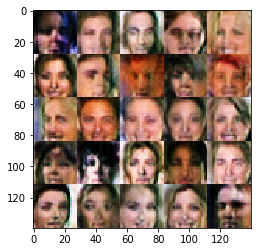

Epoch 2/2... Step 5925... Discriminator Loss: 1.3973... Generator Loss: 0.7412
Epoch 2/2... Step 5950... Discriminator Loss: 1.4036... Generator Loss: 0.6855
Epoch 2/2... Step 5975... Discriminator Loss: 1.4098... Generator Loss: 0.7739
Epoch 2/2... Step 6000... Discriminator Loss: 1.4133... Generator Loss: 0.8154


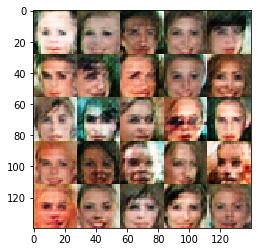

Epoch 2/2... Step 6025... Discriminator Loss: 1.3860... Generator Loss: 0.7603
Epoch 2/2... Step 6050... Discriminator Loss: 1.3881... Generator Loss: 0.8102
Epoch 2/2... Step 6075... Discriminator Loss: 1.3922... Generator Loss: 0.7732
Epoch 2/2... Step 6100... Discriminator Loss: 1.3911... Generator Loss: 0.8135


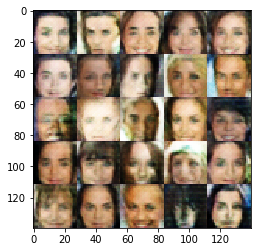

Epoch 2/2... Step 6125... Discriminator Loss: 1.3828... Generator Loss: 0.8095
Epoch 2/2... Step 6150... Discriminator Loss: 1.3953... Generator Loss: 0.7960
Epoch 2/2... Step 6175... Discriminator Loss: 1.3951... Generator Loss: 0.7659
Epoch 2/2... Step 6200... Discriminator Loss: 1.3912... Generator Loss: 0.7477


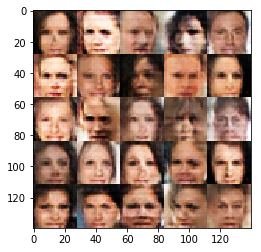

Epoch 2/2... Step 6225... Discriminator Loss: 1.3867... Generator Loss: 0.7538
Epoch 2/2... Step 6250... Discriminator Loss: 1.3852... Generator Loss: 0.8340
Epoch 2/2... Step 6275... Discriminator Loss: 1.3840... Generator Loss: 0.7760
Epoch 2/2... Step 6300... Discriminator Loss: 1.4028... Generator Loss: 0.7931


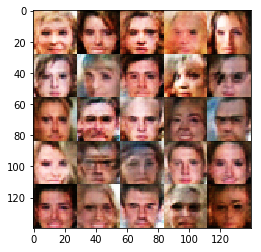

Epoch 2/2... Step 6325... Discriminator Loss: 1.3962... Generator Loss: 0.7698


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.